## Train model for Clusters

In [24]:
model_name = 'Regression'

### Import libraries

In [3]:
import numpy as np
from numpy.matlib import repmat
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import mutual_info_classif


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.model_selection import cross_validate

from matplotlib.colors import LinearSegmentedColormap
from mne import create_info
from mne.viz import plot_topomap

### Import data

In [4]:
filename = '/mnt/d/sharegit/MasterThesis_data/DWTs/pp01_t16.csv'
df = pd.read_csv(filename, header=None)
filename = '/mnt/d/sharegit/MasterThesis_data/DWTs/clustered_dataframe.csv'
df_scores = pd.read_csv(filename)
clusters = list(df_scores['eAll'])

In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
patterns = ['_d1', '_d2', '_d3', '_d4', '_d5', '_a1']
column_names = ['channels', 'ID', 'Class', 'Epoch'] + [f'{ch}{pt}' for ch in channels for pt in patterns ]

if len(column_names) != len(df.columns):
    raise ValueError(f"Number of column names ({len(column_names)}) does not match number of columns in DataFrame ({len(df.columns)})")

df.columns = column_names
df.head()

,channels,ID,Class,Epoch,Fp1_d1,Fp1_d2,Fp1_d3,Fp1_d4,Fp1_d5,Fp1_a1,...,CPz_d3,CPz_d4,CPz_d5,CPz_a1,POz_d1,POz_d2,POz_d3,POz_d4,POz_d5,POz_a1
0,5,1,1,1,0.575075,0.136032,0.123487,0.093560,0.057901,0.013945,...,0.140594,0.042888,0.025799,0.006609,0.336483,0.220715,0.231677,0.101612,0.089528,0.019985
1,5,1,1,2,0.509184,0.262941,0.106593,0.072962,0.037227,0.011093,...,0.163608,0.041396,0.009745,0.001428,0.244889,0.384025,0.221724,0.070184,0.060243,0.018934
2,5,1,1,3,0.490340,0.191802,0.204283,0.070682,0.033491,0.009402,...,0.218914,0.044268,0.010597,0.001778,0.273779,0.215197,0.395480,0.070791,0.033080,0.011673
3,5,1,1,4,0.436777,0.235945,0.218578,0.060795,0.038248,0.009657,...,0.273868,0.036003,0.010619,0.001746,0.369812,0.265958,0.274095,0.053359,0.028603,0.008174
4,5,1,1,5,0.398432,0.307515,0.197477,0.053886,0.033593,0.009097,...,0.303220,0.038299,0.007286,0.001249,0.214284,0.327662,0.322558,0.071483,0.049477,0.014537


### Load data into data_array

In [6]:
import random 
random.seed(42)

def create_all_intensity_observator(df):
    # Create an empty list to hold the concatenated data for each ID
    classes = []
    concatenated_data = []

    # Loop through each unique ID
    for ID in df['ID'].unique():
        # Filter the dataframe for the current ID
        df_temp = df[df['ID'] == ID]
        
        # List to hold the data arrays for all classes
        class_arrays = []
        
        # Loop through each unique class for the current ID
        max_c = df_temp['Class'].value_counts().max()
        min_c = df_temp['Class'].value_counts().min()
        rep_factor = max_c//min_c+1 
        for cls in df_temp['Class'].unique():
            # Filter the dataframe for the current class
            df_class = df_temp[df_temp['Class'] == cls].reset_index(drop=True)
            
            # Drop unnecessary columns
            df_class = df_class.drop(columns=['channels', 'ID', 'Class', 'Epoch'])
        
            # Convert the dataframe to a numpy array
            class_array = df_class.to_numpy()
            class_array = repmat(class_array, rep_factor, 1)
            class_array = class_array[:max_c,:]
            class_arrays.append(class_array)
        print(f'ID{ID:02d}: Repetition factor {rep_factor:02d} - Max is: {max_c:02d} - Min is: {min_c:02d}')
        p = []
        for cl in range(max_c):
            p.append(clusters[ID-1]+random.random()*2)
        
        classes = classes + p
        concatenated_data.append(np.concatenate((class_arrays),axis=1).tolist())
    final_array = np.concatenate((concatenated_data))

    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
    patterns = ['_d1', '_d2', '_d3', '_d4', '_d5', '_a1']
    mod_intensity = ['_A1','_A2','_A3','_A4','_V1','_V2','_V3','_V4','_C1','_C2','_C3','_C4']
    column_names = [f'{ch}_{pt}{mi}' for ch in channels for mi in mod_intensity for pt in patterns ]
    
    # Convert the final array to a dataframe
    final_df = pd.DataFrame(final_array, columns = column_names)

    return final_df, classes

# Example usage
final_df, classes = create_all_intensity_observator(df)

ID01: Repetition factor 03 - Max is: 16 - Min is: 06
ID02: Repetition factor 02 - Max is: 20 - Min is: 17
ID03: Repetition factor 02 - Max is: 20 - Min is: 17
ID04: Repetition factor 02 - Max is: 20 - Min is: 17
ID05: Repetition factor 02 - Max is: 20 - Min is: 15
ID06: Repetition factor 02 - Max is: 20 - Min is: 17
ID07: Repetition factor 02 - Max is: 20 - Min is: 17
ID08: Repetition factor 02 - Max is: 20 - Min is: 17
ID09: Repetition factor 02 - Max is: 20 - Min is: 17
ID10: Repetition factor 02 - Max is: 20 - Min is: 17
ID11: Repetition factor 02 - Max is: 20 - Min is: 17
ID12: Repetition factor 02 - Max is: 20 - Min is: 17
ID13: Repetition factor 02 - Max is: 19 - Min is: 14
ID14: Repetition factor 02 - Max is: 20 - Min is: 17
ID15: Repetition factor 02 - Max is: 20 - Min is: 17
ID16: Repetition factor 02 - Max is: 20 - Min is: 17
ID17: Repetition factor 02 - Max is: 20 - Min is: 17
ID18: Repetition factor 02 - Max is: 20 - Min is: 13
ID19: Repetition factor 02 - Max is: 20 - Min 

In [7]:
final_df

,Fp1__d1_A1,Fp1__d2_A1,Fp1__d3_A1,Fp1__d4_A1,Fp1__d5_A1,Fp1__a1_A1,Fp1__d1_A2,Fp1__d2_A2,Fp1__d3_A2,Fp1__d4_A2,...,POz__d3_C3,POz__d4_C3,POz__d5_C3,POz__a1_C3,POz__d1_C4,POz__d2_C4,POz__d3_C4,POz__d4_C4,POz__d5_C4,POz__a1_C4
0,0.575075,0.136032,0.123487,0.093560,0.057901,0.013945,0.547423,0.179707,0.128436,0.079774,...,0.120006,0.058866,0.018769,0.004650,0.310979,0.280219,0.148740,0.145800,0.084847,0.029415
1,0.509184,0.262941,0.106593,0.072962,0.037227,0.011093,0.454395,0.294668,0.132037,0.068668,...,0.055985,0.024101,0.008343,0.001890,0.374326,0.261388,0.189394,0.089160,0.064557,0.021176
2,0.490340,0.191802,0.204283,0.070682,0.033491,0.009402,0.449821,0.230215,0.206960,0.072723,...,0.108032,0.034976,0.009704,0.002487,0.310311,0.371701,0.153067,0.090099,0.057843,0.016979
3,0.436777,0.235945,0.218578,0.060795,0.038248,0.009657,0.404348,0.271724,0.228696,0.058293,...,0.092514,0.037553,0.011085,0.002544,0.415283,0.204239,0.225839,0.088631,0.047929,0.018078
4,0.398432,0.307515,0.197477,0.053886,0.033593,0.009097,0.347098,0.329096,0.221465,0.060126,...,0.085023,0.024561,0.011938,0.003414,0.363550,0.392284,0.128789,0.063558,0.035549,0.016269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0.520923,0.146249,0.227325,0.077945,0.023838,0.003721,0.511574,0.197145,0.186010,0.082555,...,0.221002,0.097901,0.021570,0.002329,0.465205,0.157267,0.255658,0.082686,0.033793,0.005391
671,0.440654,0.148458,0.309111,0.078313,0.019596,0.003868,0.348667,0.201904,0.304249,0.123013,...,0.199921,0.169995,0.028542,0.004070,0.304721,0.153519,0.279493,0.200074,0.053543,0.008649
672,0.301289,0.144256,0.421904,0.102509,0.026651,0.003391,0.348306,0.121300,0.403601,0.092343,...,0.202985,0.164066,0.021850,0.002545,0.430492,0.186828,0.221463,0.127088,0.029180,0.004949
673,0.405805,0.160670,0.293036,0.117079,0.020803,0.002607,0.401348,0.154556,0.297756,0.113953,...,0.193004,0.116954,0.023412,0.002485,0.412937,0.182140,0.255691,0.107749,0.036119,0.005365


In [8]:
print(len(classes))
data_array = final_df.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_array, classes, test_size=0.2, random_state=42)

675


### Train models

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
import numpy as np

def print_regression_scores(name, scores):
    mean_test_neg_mse = -np.mean(scores['test_neg_mean_squared_error'])
    std_test_neg_mse = np.std(scores['test_neg_mean_squared_error'])
    mean_test_neg_mae = -np.mean(scores['test_neg_mean_absolute_error'])
    mean_test_r2 = np.mean(scores['test_r2'])
    mean_test_ev = np.mean(scores['test_explained_variance'])

    print(f"------------------------------------------------------------")
    print(f"Average K-Fold Test MSE of {name}: {mean_test_neg_mse:.2f}")
    print(f"Std Dev of K-Fold Test MSE of {name}: {std_test_neg_mse:.2f}")
    print(f"Average K-Fold Test MAE of {name}: {mean_test_neg_mae:.2f}")
    print(f"Average K-Fold Test R2 of {name}: {mean_test_r2:.2f}")
    print(f"Average K-Fold Test Explained Variance of {name}: {mean_test_ev:.2f}")
    print(f"------------------------------------------------------------")

def RForest_train_regression(X_train, y_train, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', validation='standard', cv=5, echo=True):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                  max_features=max_features, random_state=42)
    
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'explained_variance']
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)

    model.fit(X_train, y_train)
    
    if echo:
        print_regression_scores('Random Forest', scores)
    return scores, model

def KNN_train_regression(X_train, y_train, hot_encode=False, n_neighbors=20, p=1, weights='distance', leaf_size=20, algorithm='auto', validation='standard', cv=5, echo=True):
    model = KNeighborsRegressor(n_neighbors=n_neighbors, p=p, weights=weights, leaf_size=leaf_size, algorithm=algorithm)

    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'explained_variance']
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    if echo:
        print_regression_scores('KNN', scores)
    return scores, model

def MLP_train_regression(X_train, y_train, hot_encode=False, hidden_layer_sizes=(100,), activation='relu', solver='adam', validation='standard', alpha=0.001, cv=5, max_iter=200, echo=True):
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, batch_size='auto', learning_rate='constant', 
                         learning_rate_init=0.001, power_t=0.5, max_iter=max_iter, shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                         warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
                         beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'explained_variance']
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    model.fit(X_train, y_train)

    if echo:
        print_regression_scores('MLP', scores)
    return scores, model

def train_all_regression(X_train, y_train, cv=10, echo=True):
    models = []
    scores = []
    
    score, model = KNN_train_regression(X_train, y_train, cv=cv, echo=echo)
    models.append(model)
    scores.append(score)
    
    score, model = RForest_train_regression(X_train, y_train, cv=cv,echo=echo)
    models.append(model)
    scores.append(score)
    
    score, model = MLP_train_regression(X_train, y_train, hidden_layer_sizes=(200, 100, 50), max_iter=10000, alpha=0.001, cv=cv,echo=echo)
    models.append(model)
    scores.append(score)
    
    return models, scores

models, scores = train_all_regression(X_train, y_train)


------------------------------------------------------------
Average K-Fold Test MSE of KNN: 11.24
Std Dev of K-Fold Test MSE of KNN: 2.74
Average K-Fold Test MAE of KNN: 2.62
Average K-Fold Test R2 of KNN: 0.82
Average K-Fold Test Explained Variance of KNN: 0.83
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test MSE of Random Forest: 15.81
Std Dev of K-Fold Test MSE of Random Forest: 2.79
Average K-Fold Test MAE of Random Forest: 3.27
Average K-Fold Test R2 of Random Forest: 0.75
Average K-Fold Test Explained Variance of Random Forest: 0.75
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test MSE of MLP: 6.67
Std Dev of K-Fold Test MSE of MLP: 1.41
Average K-Fold Test MAE of MLP: 2.04
Average K-Fold Test R2 of MLP: 0.89
Average K-Fold Test Explained Variance of MLP: 0.90
-------------------------------------

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calculate_regression_scores(X_test, y_test, models):
    ensemble_preds = np.zeros((len(y_test), len(models)))
    mses = []
    maes = []
    r2s = []
    
    # Loop over each model to get predictions and calculate individual metrics
    for i, (model, name) in enumerate(zip(models, ['KNN', 'Random Forest', 'MLP'])):
        pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        
        mses.append(mse)
        maes.append(mae)
        r2s.append(r2)
        
        print(f"{name} Mean Squared Error: {mse}")
        print(f"{name} Mean Absolute Error: {mae}")
        print(f"{name} R2 Score: {r2}")
        
        # Store the predictions for ensemble averaging
        ensemble_preds[:, i] = pred

    # Average the predictions for ensemble
    ensemble_final_preds = np.mean(ensemble_preds, axis=1)
    
    # Calculate the ensemble metrics
    ensemble_mse = mean_squared_error(y_test, ensemble_final_preds)
    ensemble_mae = mean_absolute_error(y_test, ensemble_final_preds)
    ensemble_r2 = r2_score(y_test, ensemble_final_preds)
    
    print(f"Ensemble Mean Squared Error: {ensemble_mse}")
    print(f"Ensemble Mean Absolute Error: {ensemble_mae}")
    print(f"Ensemble R2 Score: {ensemble_r2}")
    
    return mses, maes, r2s, ensemble_preds

mses, maes, r2s, ensemble_preds = calculate_regression_scores(X_test, y_test, models)


KNN Mean Squared Error: 8.043455305670681
KNN Mean Absolute Error: 2.187637500821915
KNN R2 Score: 0.861328365010727
Random Forest Mean Squared Error: 14.266319619466644
Random Forest Mean Absolute Error: 3.013073953987033
Random Forest R2 Score: 0.7540442767778859
MLP Mean Squared Error: 7.307998607594154
MLP Mean Absolute Error: 2.150086570881599
MLP R2 Score: 0.8740078639213733
Ensemble Mean Squared Error: 7.697953368074675
Ensemble Mean Absolute Error: 2.176700753868386
Ensemble R2 Score: 0.8672849243198366


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_regression_results(y_test, predictions, model_name):
    # Scatter plot of predicted vs actual values
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} Predicted vs Actual Values')
    plt.grid(False)
    
    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y_test - predictions
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.hlines(y=0, xmin=min(predictions), xmax=max(predictions), linestyles='--', color = 'red')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} Residual Plot')
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()


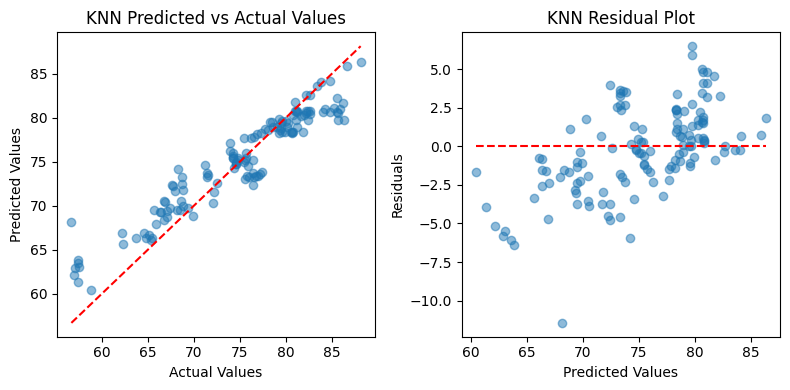

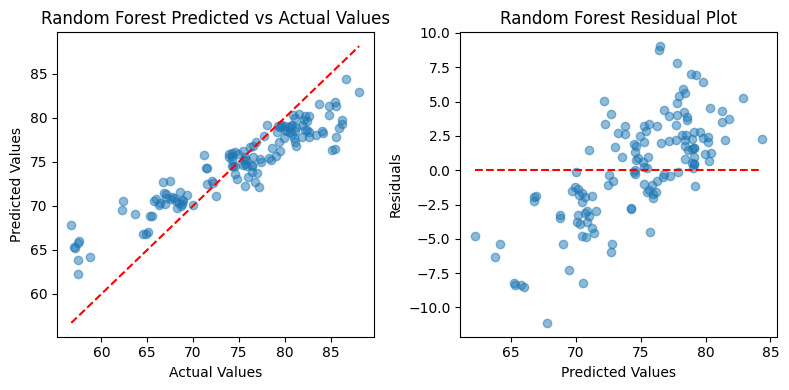

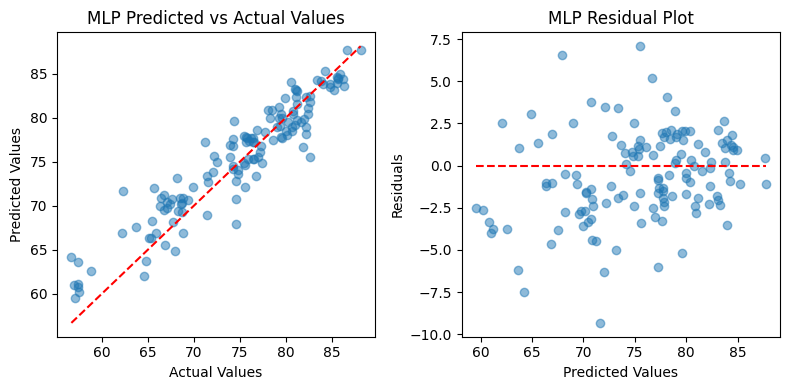

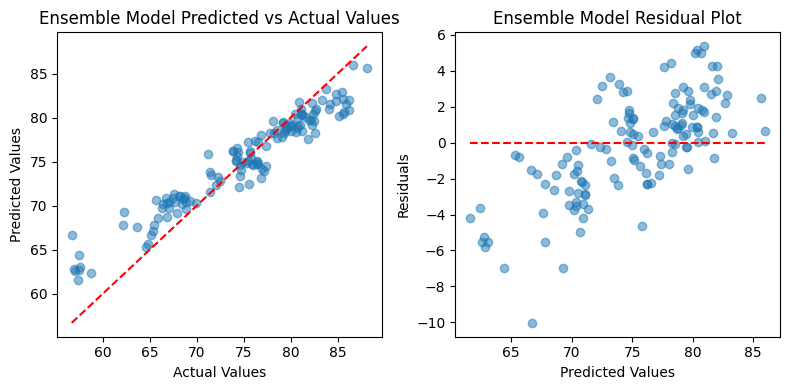

In [11]:
ensemble_predictions = np.mean(ensemble_preds, axis=1)

knn_predictions = models[0].predict(X_test)
rf_predictions = models[1].predict(X_test)
mlp_predictions = models[2].predict(X_test)

plot_regression_results(y_test, knn_predictions, 'KNN')
plot_regression_results(y_test, rf_predictions, 'Random Forest')
plot_regression_results(y_test, mlp_predictions, 'MLP')

ensemble_predictions = np.mean(ensemble_preds, axis=1)
plot_regression_results(y_test, ensemble_predictions, 'Ensemble Model')

### Feature Selection

In [12]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression

def get_mutualInfo_regression(X_train, X_test, y_train, number_of_f=100):
    # Calculate mutual information scores
    mutual_info_scores = mutual_info_regression(X_train, y_train)
    
    if number_of_f > 0:
        # Sort the mutual information scores in descending order and select the top n features
        sorted_indices = np.argsort(mutual_info_scores)[::-1]
        selected_features = sorted_indices[:number_of_f]
    else:
        raise ValueError("Number of features must be greater than 0.")

    # Filter the training and test sets to include only the selected features
    X_train_sf = X_train[:, selected_features]
    X_test_sf = X_test[:, selected_features]

    # Define the channels and patterns
    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
    patterns = ['d1', 'd2', 'd3', 'd4', 'd5', 'a1']
    mod_intensity = ['A1', 'A2', 'A3', 'A4', 'V1', 'V2', 'V3', 'V4', 'C1', 'C2', 'C3', 'C4']
    feature_names = [f'{ch}_{pt}_{mi}' for ch in channels for pt in patterns for mi in mod_intensity]
    
    if len(feature_names) != len(mutual_info_scores):
        raise ValueError(f"The number of generated feature names ({len(feature_names)}) does not match the number of features ({len(mutual_info_scores)}) in the data.")
    
    # Print the mutual information scores of the top n features
    print(f"Top {number_of_f} most important features:")
    for i in selected_features:
        print(f"{feature_names[i]}: Mutual Information Score: {mutual_info_scores[i]:.5f}")
    
    # Print the number of selected features
    print(f"Number of features selected: {len(selected_features)}")
    
    return X_train_sf, X_test_sf

X_train_sf, X_test_sf = get_mutualInfo_regression(X_train, X_test, y_train, number_of_f=30)


Top 30 most important features:
F3_d4_C4: Mutual Information Score: 0.51159
C3_d3_C3: Mutual Information Score: 0.50550
P3_d2_C4: Mutual Information Score: 0.49809
P3_d5_V1: Mutual Information Score: 0.48853
Cz_d5_V1: Mutual Information Score: 0.48677
T7_d2_A4: Mutual Information Score: 0.47845
F4_d1_V1: Mutual Information Score: 0.47538
C3_d3_V2: Mutual Information Score: 0.47410
Cz_d2_C4: Mutual Information Score: 0.46928
AFz_d1_C4: Mutual Information Score: 0.46764
T8_d4_C4: Mutual Information Score: 0.46171
C3_a1_A4: Mutual Information Score: 0.45765
C3_d3_C4: Mutual Information Score: 0.45575
F4_d1_A4: Mutual Information Score: 0.44755
P3_d3_V1: Mutual Information Score: 0.44602
T7_a1_C2: Mutual Information Score: 0.44553
Fp1_d1_V1: Mutual Information Score: 0.44440
Fp1_d5_C4: Mutual Information Score: 0.44407
Fp2_d2_A4: Mutual Information Score: 0.43853
AFz_d4_V1: Mutual Information Score: 0.43651
Cz_d5_V2: Mutual Information Score: 0.43619
T8_d4_C3: Mutual Information Score: 0.4

In [13]:
models, scores = train_all(X_train_sf, y_train)

------------------------------------------------------------
Average K-Fold Test MSE of KNN: 16.41
Std Dev of K-Fold Test MSE of KNN: 3.73
Average K-Fold Test MAE of KNN: 3.19
Average K-Fold Test R2 of KNN: 0.74
Average K-Fold Test Explained Variance of KNN: 0.74
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test MSE of Random Forest: 14.45
Std Dev of K-Fold Test MSE of Random Forest: 3.82
Average K-Fold Test MAE of Random Forest: 2.93
Average K-Fold Test R2 of Random Forest: 0.77
Average K-Fold Test Explained Variance of Random Forest: 0.77
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test MSE of MLP: 23.13
Std Dev of K-Fold Test MSE of MLP: 6.46
Average K-Fold Test MAE of MLP: 3.70
Average K-Fold Test R2 of MLP: 0.62
Average K-Fold Test Explained Variance of MLP: 0.63
------------------------------------

In [14]:
mses, maes, r2s, ensemble_preds = calculate_regression_scores(X_test_sf, y_test, models)

KNN Mean Squared Error: 11.491987869455096
KNN Mean Absolute Error: 2.5911848603508987
KNN R2 Score: 0.8018746065499083
Random Forest Mean Squared Error: 14.045271260669749
Random Forest Mean Absolute Error: 2.7968426237012856
Random Forest R2 Score: 0.7578552182403753
MLP Mean Squared Error: 19.18699426068877
MLP Mean Absolute Error: 3.386442418871588
MLP R2 Score: 0.6692103376538056
Ensemble Mean Squared Error: 11.680253061465221
Ensemble Mean Absolute Error: 2.607425616446206
Ensemble R2 Score: 0.7986288569316804


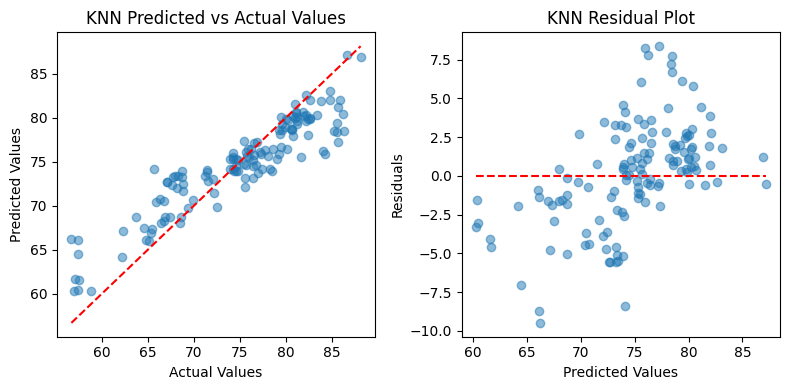

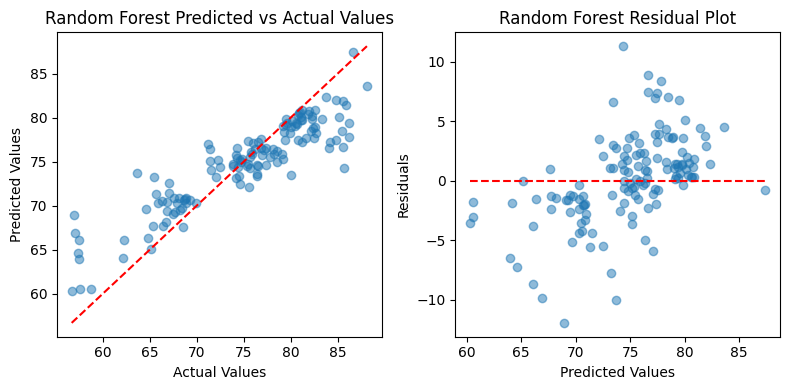

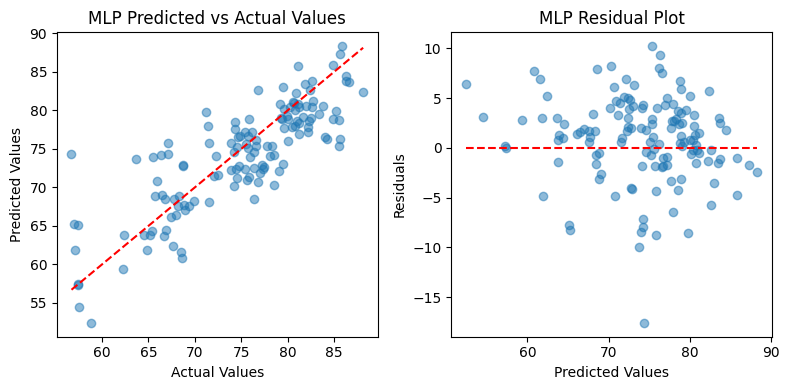

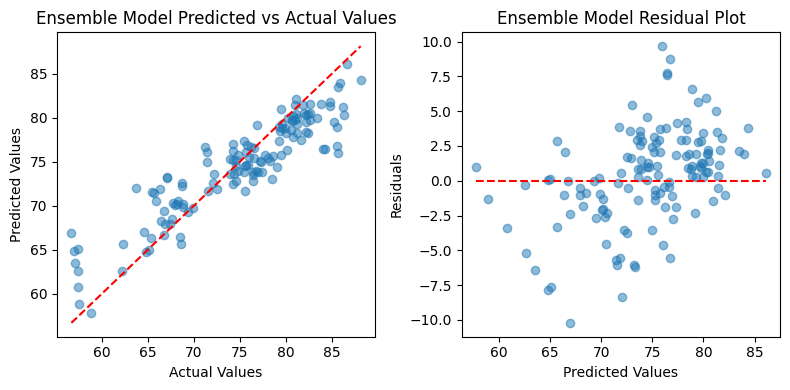

In [15]:
knn_predictions = models[0].predict(X_test_sf)
rf_predictions = models[1].predict(X_test_sf)
mlp_predictions = models[2].predict(X_test_sf)

plot_regression_results(y_test, knn_predictions, 'KNN')
plot_regression_results(y_test, rf_predictions, 'Random Forest')
plot_regression_results(y_test, mlp_predictions, 'MLP')

ensemble_predictions = np.mean(ensemble_preds, axis=1)
plot_regression_results(y_test, ensemble_predictions, 'Ensemble Model')


In [22]:
def get_mutualInfo(X_train, y_train, number_of_f=100):
    mutual_info_scores = mutual_info_regression(X_train, y_train)
    sorted_indices = np.argsort(mutual_info_scores)[::-1]
    selected_features = sorted_indices[:number_of_f]
    X_train_sf = X_train[:, selected_features]
    feature_names = [f'Feature {i+1}' for i in selected_features]
    return X_train_sf, selected_features, feature_names

def feature_selection_and_model_training(X_train, X_test, y_train, y_test, feature_counts, cv=5):
    results = []
    models_all = []
    for count in feature_counts:
        X_train_sf, selected_features, feature_names = get_mutualInfo(X_train, y_train, number_of_f=count)
        X_test_sf = X_test[:, selected_features]
        print(f'Computed features {count}')
        models, scores = train_all(X_train_sf, y_train,  echo=False)
        
        model_all = {
            'KNN': models[0],
            'RF': models[1],
            'MLP': models[2],
        }  
        models_all.append(model_all)
        
        for model, score, name in zip(models, scores, ['KNN', 'RF', 'MLP']):                          
            y_pred_sf = model.predict(X_test_sf)
            
            result = {
                'name': name,
                'features': count,
                'test_neg_mean_squared_error': -np.mean(score['test_neg_mean_squared_error']),
                'std_neg_mean_squared_error': np.std(score['test_neg_mean_squared_error']),
                'test_neg_mean_absolute_error': -np.mean(score['test_neg_mean_absolute_error']),
                'test_r2': np.mean(score['test_r2']),
                'test_explained_variance': np.mean(score['test_explained_variance']),
                'retained_features': selected_features
            }
            results.append(result)
    
    return results, models_all

In [23]:
feature_counts = np.array([1, 5, 10, 20, 30, 40])
results, models_all = feature_selection_and_model_training(X_train, X_test, y_train, y_test, feature_counts, cv=5)

Computed features 1
Computed features 5
Computed features 10
Computed features 20
Computed features 30
Computed features 40


In [24]:
def plot_features_vs_metric(results, metric):
    plt.figure(figsize=(10, 6))
    
    models = ['KNN', 'RF', 'MLP']
    for model in models:
        feature_counts = [result['features'] for result in results if result['name'] == model]
        metrics = [result[metric] for result in results if result['name'] == model]
        plt.plot(feature_counts, metrics, marker='o', label=model)
    
    plt.xlabel('Number of Features')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Number of Features vs. {metric.replace("_", " ").title()}')
    plt.legend()
    plt.grid(True)
    plt.show()

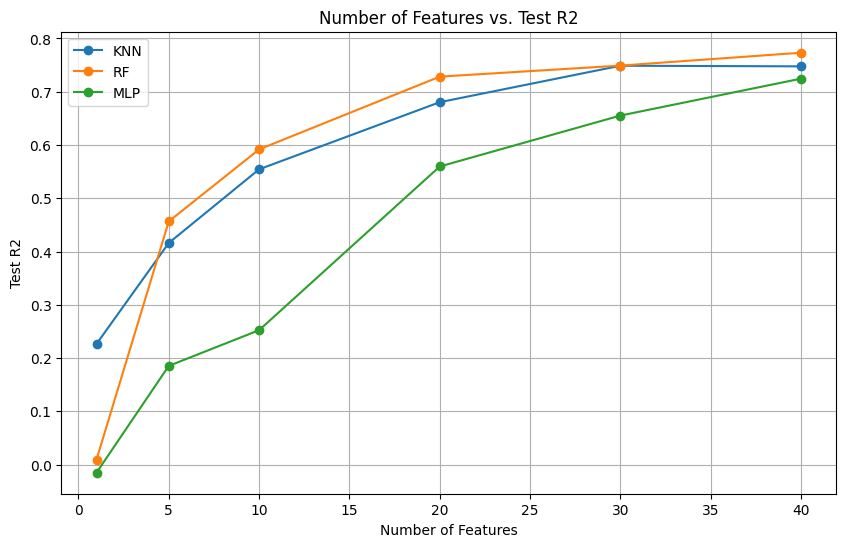

In [25]:
plot_features_vs_metric(results, 'test_r2')

# Compute Feature vs. metric

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import mutual_info_regression, RFECV
from mrmr import mrmr_regression
from sklearn.svm import SVR
import pickle
from sklearn.model_selection import KFold

def get_mutualInfo_regression(X_train, y_train, number_of_f=100):
    mutual_info_scores = mutual_info_regression(X_train, y_train)
    sorted_indices = np.argsort(mutual_info_scores)[::-1]
    selected_features = sorted_indices[:number_of_f]
    X_train_sf = X_train[:, selected_features]
    feature_names = [f'Feature {i+1}' for i in selected_features]  
    return X_train_sf, selected_features

def get_mRMR_regression(X_train, y_train, number_of_f=100):
    X = pd.DataFrame(X_train)
    y = pd.Series(y_train)
    selected_features = mrmr_regression(X, y, K=number_of_f)
    X_train_sf = X_train[:, selected_features]
    return X_train_sf, selected_features

def get_svm_rfe_regression(X_train, y_train, number_of_f=100):
    svr = SVR(kernel="linear")
    rfecv = RFECV(estimator=svr, step=1, cv=KFold(5), scoring='neg_mean_squared_error')
    rfecv.fit(X_train, y_train)
    selected_features = np.argsort(rfecv.ranking_)[:number_of_f]
    X_train_sf = X_train[:, selected_features]
    return X_train_sf, selected_features

# Could further add the metrics for ensemble model 
def feature_selection_and_model_training_reg(X_train, X_test, y_train, y_test, feature_counts, method='mutual_info', cv=5):
    results = []
    models_all = []
    for count in feature_counts:
        if method == 'mutual_info':
            X_train_sf, selected_features = get_mutualInfo_regression(X_train, y_train, number_of_f=count)
        elif method == 'mrmr':
            X_train_sf, selected_features = get_mRMR_regression(X_train, y_train, number_of_f=count)
        elif method == 'svm_rfe':
            X_train_sf, selected_features = get_svm_rfe_regression(X_train, y_train, number_of_f=count)
        else:
            raise ValueError(f"Unknown feature selection method: {method}")
        
        X_test_sf = X_test[:, selected_features]
        print(f'Computed features {count} using {method}')
        models, scores = train_all_regression(X_train_sf, y_train, cv=cv, echo=False)
        
        model_all = {
            'KNN': models[0],
            'RF': models[1],
            'MLP': models[2],
        }  
        models_all.append(model_all)
        
        for model, score, name in zip(models, scores, ['KNN', 'RF', 'MLP']):                          
            y_pred_sf = model.predict(X_test_sf)
            result = {
                'name': name,
                'features': count,
                'test_neg_mean_squared_error': -np.mean(score['test_neg_mean_squared_error']),
                'std_neg_mean_squared_error': np.std(score['test_neg_mean_squared_error']),
                'test_neg_mean_absolute_error': -np.mean(score['test_neg_mean_absolute_error']),
                'test_r2': np.mean(score['test_r2']),
                'test_explained_variance': np.mean(score['test_explained_variance']),
                'retained_features': selected_features
            }
            results.append(result)

    return results, models_all

def plot_features_vs_accuracy_regression(results, metric = 'test_neg_mean_squared_error', title = 'Mutual Information'):
    plt.figure(figsize=(5, 5))
    
    models = ['KNN', 'RF', 'MLP']
    for model in models:
        feature_counts = [result['features'] for result in results if result['name'] == model]
        test_accuracies = [result[metric] for result in results if result['name'] == model]
        plt.plot(feature_counts, test_accuracies, label=model)
    
    plt.xlabel('Number of Features')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(title)
    plt.legend()
    plt.ylim((2.3, 6))
    plt.grid(True)
    plt.show()


def save_to_pkl(filename, obj):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)

def load_from_pkl(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [106]:
from collections import Counter

# Define the channels, patterns, and mod_intensity
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
patterns = ['d1', 'd2', 'd3', 'd4', 'd5', 'a1']
mod_intensity = ['A1', 'A2', 'A3', 'A4', 'V1', 'V2', 'V3', 'V4', 'C1', 'C2', 'C3', 'C4']
feature_names = [f'{ch}_{pt}_{mi}' for ch in channels for pt in patterns for mi in mod_intensity]

def get_best_model(results, metric='test_neg_mean_squared_error'):
    best_metric = float('inf')
    best_model_info = None
    
    for result in results:
        if result[metric] < best_metric:
            best_metric = result[metric]
            best_model_info = result
    
    return best_metric, best_model_info

# Function to find the most repeated components for the best accuracy
def most_repeated_components_best_accuracy_regression(results, feature_names, metric='test_neg_mean_squared_error'):
    # Identify the best accuracy and the corresponding number of features
    best_metric = float('inf')
    best_features_count = 0
    
    for result in results:
        if result[metric] < best_metric:
            best_metric = result[metric]
            best_features_count = result['features']
    
    # Filter results for the best number of features
    best_results = [result for result in results if result['features'] == best_features_count]
    
    # Initialize counters
    channel_counter = Counter()
    pattern_counter = Counter()
    mod_intensity_counter = Counter()
    
    # Count occurrences of each component
    for result in best_results:
        retained_features = result['retained_features']
        for feature_idx in retained_features:
            feature_name = feature_names[feature_idx]
            channel, pattern, mod_intensity = feature_name.split('_')
            
            channel_counter[channel] += 1
            pattern_counter[pattern] += 1
            mod_intensity_counter[mod_intensity] += 1
    
    # Get the most common components
    most_common_channels = channel_counter.most_common()
    most_common_patterns = pattern_counter.most_common()
    most_common_mod_intensity = mod_intensity_counter.most_common()
    
    return most_common_channels, most_common_patterns, most_common_mod_intensity, best_metric, best_features_count

def print_best_most_common_regression(loaded_results, feature_names, metric='test_neg_mean_squared_error'):
    most_common_channels, most_common_patterns, most_common_mod_intensity, best_metric, best_features_count = most_repeated_components_best_accuracy_regression(loaded_results, feature_names, metric = metric)
    best_metric, best_model_info = get_best_model(loaded_results, metric = metric)

    # Print the best accuracy and the number of features
    print(f"Best Metric (Lowest Error): {best_metric:.2f} with {best_features_count} features\n")
    print("Best Model Info:")
    print(f"Model Name: {best_model_info['name']}")
    print(f"Number of Features: {best_model_info['features']}")
    print(f"Test Negative Mean Squared Error: {best_model_info['test_neg_mean_squared_error']:.2f}")
    print(f"Standard Deviation of Negative Mean Squared Error: {best_model_info['std_neg_mean_squared_error']:.2f}")
    print(f"Test Negative Mean Absolute Error: {best_model_info['test_neg_mean_absolute_error']:.2f}")
    print(f"Test Explained Variance: {best_model_info['test_explained_variance']:.2f}")
   
    # Print the top most common channels, patterns, and modulation intensities
    print("\nTop most common channels:")
    for channel, count in most_common_channels:
        print(f"{channel}: {count} times")
    
    print("\nTop most common patterns:")
    for pattern, count in most_common_patterns:
        print(f"{pattern}: {count} times")
    
    print("\nTop most common modulation intensities:")
    for mod_intensity, count in most_common_mod_intensity:
        print(f"{mod_intensity}: {count} times")

## Compute Feature vs. metric curve

### SVM-RFE Regression

In [39]:
feature_counts = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,60,65,70,75,80])
results, models_all = feature_selection_and_model_training_reg(X_train, X_test, y_train, y_test, feature_counts, method='svm_rfe', cv=5)

filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/svm_rfe_reg_results.pkl'
save_to_pkl(filename, results)
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/svm_rfe_reg_models_all.pkl'
save_to_pkl(filename, models_all)

Computed features 1 using svm_rfe
Computed features 5 using svm_rfe
Computed features 10 using svm_rfe
Computed features 15 using svm_rfe
Computed features 20 using svm_rfe
Computed features 25 using svm_rfe
Computed features 30 using svm_rfe
Computed features 35 using svm_rfe
Computed features 40 using svm_rfe
Computed features 45 using svm_rfe
Computed features 50 using svm_rfe
Computed features 55 using svm_rfe
Computed features 60 using svm_rfe
Computed features 65 using svm_rfe
Computed features 70 using svm_rfe
Computed features 75 using svm_rfe
Computed features 80 using svm_rfe


### Mutual information Regression

In [22]:
feature_counts = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,60,65,70,75,80])
results, models_all = feature_selection_and_model_training_reg(X_train, X_test, y_train, y_test, feature_counts, method='mutual_info', cv=5)

filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mutual_info_reg_results.pkl'
save_to_pkl(filename, results)
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mutual_info_reg_models_all.pkl'
save_to_pkl(filename, models_all)

Computed features 1 using mutual_info
Computed features 5 using mutual_info
Computed features 10 using mutual_info
Computed features 15 using mutual_info
Computed features 20 using mutual_info
Computed features 25 using mutual_info
Computed features 30 using mutual_info
Computed features 35 using mutual_info
Computed features 40 using mutual_info
Computed features 45 using mutual_info
Computed features 50 using mutual_info
Computed features 55 using mutual_info
Computed features 60 using mutual_info
Computed features 65 using mutual_info
Computed features 70 using mutual_info
Computed features 75 using mutual_info
Computed features 80 using mutual_info


### mRMR Regression

In [28]:
feature_counts = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
results, models_all = feature_selection_and_model_training_reg(X_train, X_test, y_train, y_test, feature_counts, method='mrmr', cv=5)

filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mrmr_reg_results.pkl'
save_to_pkl(filename, results)
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mrmr_reg_models_all.pkl'
save_to_pkl(filename, models_all)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 666.19it/s]


Computed features 1 using mrmr


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.72it/s]


Computed features 5 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.68it/s]


Computed features 10 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 27.89it/s]


Computed features 15 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.06it/s]


Computed features 20 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 26.78it/s]


Computed features 25 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.83it/s]


Computed features 30 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 26.66it/s]


Computed features 35 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.49it/s]


Computed features 40 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 26.28it/s]


Computed features 45 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.03it/s]


Computed features 50 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 25.95it/s]


Computed features 55 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.23it/s]


Computed features 60 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 26.24it/s]


Computed features 65 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.22it/s]


Computed features 70 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 25.55it/s]


Computed features 75 using mrmr


100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 26.27it/s]


Computed features 80 using mrmr


## Plot Curve

### SVM-RFE

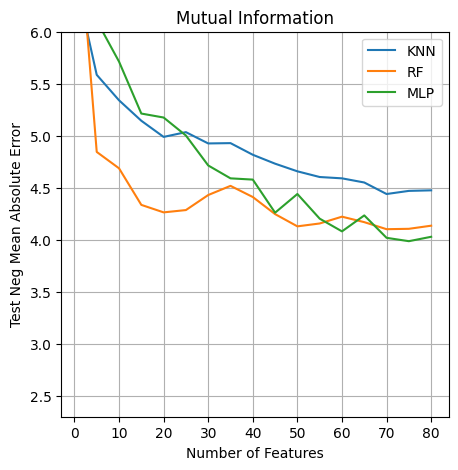

In [107]:
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/svm_rfe_reg_results.pkl'
loaded_results = load_from_pkl(filename)
plot_features_vs_accuracy_regression(loaded_results, metric = 'test_neg_mean_absolute_error')

### Mutual information

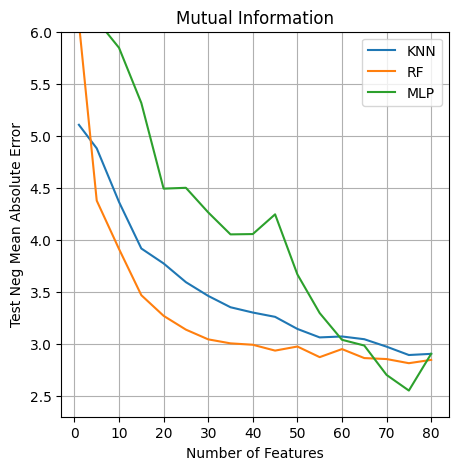

In [108]:
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mutual_info_reg_results.pkl'
loaded_results = load_from_pkl(filename)
plot_features_vs_accuracy_regression(loaded_results, metric = 'test_neg_mean_absolute_error')

### mRMR

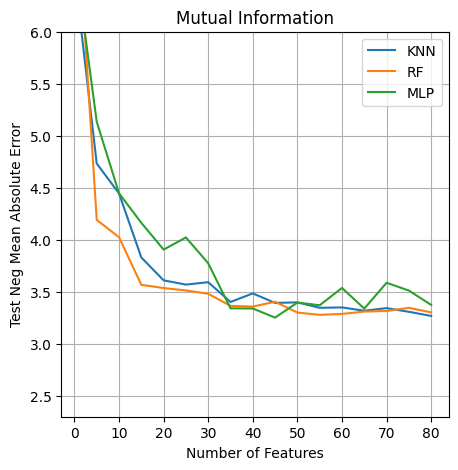

In [109]:
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mrmr_reg_results.pkl'
loaded_results = load_from_pkl(filename)
plot_features_vs_accuracy_regression(loaded_results, metric = 'test_neg_mean_absolute_error')

### Using best models

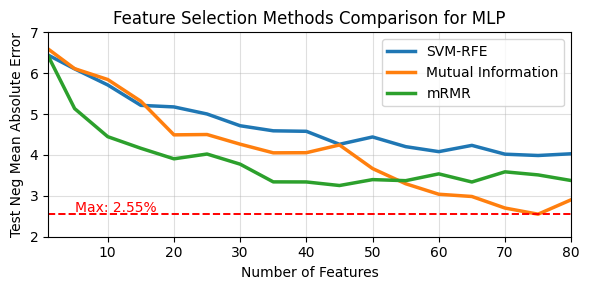

In [119]:
filenames = ['/mnt/d/sharegit/MasterThesis_data/' + model_name + '/svm_rfe_reg_results.pkl',
             '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mutual_info_reg_results.pkl',
             '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mrmr_reg_results.pkl']

feature_methods = ['SVM-RFE', 'Mutual Information', 'mRMR']
models = ['MLP', 'MLP', 'MLP']
metric = 'test_neg_mean_absolute_error'
test_neg_mean_absolute_error = 2.55

plt.figure(figsize=(6, 3))  # Adjust figure size to match the example

for filename, method, model in zip(filenames, feature_methods, models):
    loaded_results = load_from_pkl(filename)
    feature_counts = [result['features'] for result in loaded_results if result['name'] == model]
    test_accuracies = [result[metric] for result in loaded_results if result['name'] == model]
    plt.plot(feature_counts, test_accuracies, label=method, linewidth=2.5)

plt.xlabel('Number of Features')
plt.ylabel(metric.replace('_', ' ').title())
plt.title('Feature Selection Methods Comparison for ' + model)
plt.legend()
plt.ylim((2, 7))
plt.xlim((1, 80))
plt.grid(False)
plt.axhline(y=test_neg_mean_absolute_error, color = 'r', linestyle = '--', linewidth = 1.4)
plt.text(5, test_neg_mean_absolute_error*1.06, f'Max: {test_neg_mean_absolute_error}%', color='r', va='center', ha='left', fontsize=10)
plt.tight_layout()
plt.grid(alpha=.4)

plt.show()

## Best feature

In [93]:
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/svm_rfe_reg_results.pkl'
loaded_results = load_from_pkl(filename)
print(f'SVM-RFE')
print_best_most_common_regression(loaded_results, feature_names, metric = 'test_neg_mean_absolute_error')

SVM-RFE
Best Metric (Lowest Error): 3.99 with 75 features

Best Model Info:
Model Name: MLP
Number of Features: 75
Test Negative Mean Squared Error: 25.71
Standard Deviation of Negative Mean Squared Error: 4.00
Test Negative Mean Absolute Error: 3.99
Test Explained Variance: 0.60

Top most common channels:
P7: 147 times
T8: 69 times
P8: 9 times

Top most common patterns:
a1: 72 times
d5: 69 times
d4: 36 times
d3: 33 times
d1: 12 times
d2: 3 times

Top most common modulation intensities:
A1: 27 times
A3: 21 times
A2: 21 times
C4: 18 times
C3: 18 times
C2: 18 times
C1: 18 times
V4: 18 times
V1: 18 times
A4: 18 times
V3: 15 times
V2: 15 times


In [94]:
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mutual_info_reg_results.pkl'
loaded_results = load_from_pkl(filename)
print(f'Mutual Information')
print_best_most_common_regression(loaded_results, feature_names, metric = 'test_neg_mean_absolute_error')

Mutual Information
Best Metric (Lowest Error): 2.55 with 75 features

Best Model Info:
Model Name: MLP
Number of Features: 75
Test Negative Mean Squared Error: 11.32
Standard Deviation of Negative Mean Squared Error: 1.09
Test Negative Mean Absolute Error: 2.55
Test Explained Variance: 0.83

Top most common channels:
P3: 30 times
C3: 24 times
Cz: 18 times
F4: 18 times
C4: 18 times
F3: 15 times
AFz: 15 times
Fp1: 15 times
O2: 9 times
F8: 9 times
Fz: 9 times
T7: 6 times
T8: 6 times
Fp2: 6 times
P7: 6 times
CPz: 6 times
P8: 3 times
POz: 3 times
F7: 3 times
P4: 3 times
O1: 3 times

Top most common patterns:
d5: 48 times
d1: 45 times
d4: 36 times
d3: 33 times
a1: 33 times
d2: 30 times

Top most common modulation intensities:
C3: 54 times
C4: 45 times
V2: 45 times
V1: 36 times
A4: 30 times
C2: 9 times
A2: 3 times
C1: 3 times


In [95]:
filename = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/mrmr_reg_results.pkl'
loaded_results = load_from_pkl(filename)
print(f'mRMR')
print_best_most_common_regression(loaded_results, feature_names, metric = 'test_neg_mean_absolute_error')

mRMR
Best Metric (Lowest Error): 3.25 with 45 features

Best Model Info:
Model Name: MLP
Number of Features: 45
Test Negative Mean Squared Error: 17.38
Standard Deviation of Negative Mean Squared Error: 2.19
Test Negative Mean Absolute Error: 3.25
Test Explained Variance: 0.73

Top most common channels:
POz: 12 times
O1: 12 times
P8: 12 times
F7: 12 times
Fp2: 12 times
Fp1: 9 times
F4: 9 times
P7: 9 times
Fz: 9 times
Cz: 6 times
T7: 6 times
Pz: 6 times
CPz: 6 times
AFz: 3 times
C4: 3 times
O2: 3 times
C3: 3 times
P3: 3 times

Top most common patterns:
d5: 36 times
d1: 30 times
d3: 24 times
d2: 18 times
d4: 15 times
a1: 12 times

Top most common modulation intensities:
A4: 30 times
A2: 21 times
C1: 18 times
V1: 15 times
V2: 12 times
A3: 12 times
A1: 9 times
V3: 6 times
V4: 6 times
C4: 6 times
